In [8]:
# Mounted drive to this network. 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [48]:
data_path1='drive/Shared with me/Data_Images/' # didn't work
data_path3='drive/My Drive/Colab Notebooks/RealFake/RealFake/'
data_path2='drive/My Drive/Colab Notebooks/Data_Images2/' #no need

In [49]:
real_path = data_path3+'real/'
fake_path = data_path3+'fake/'

In [ ]:
import os
import cv2
import imghdr
import fnmatch
import shutil

# Creating real, fake subfolders in a 'RealFake' directory
# (ONLY RUN IF YOU DON"T HAVE THE subfolders yet)
for filename in os.listdir(data_path2):
  source=data_path2+filename

  if fnmatch.fnmatch(filename, '*_0.png'):
    dest_real=real_path+filename
    shutil.move(source, dest_real)

  if fnmatch.fnmatch(filename, '*_1.png'):
    dest_fake=fake_path+filename
    shutil.move(source, dest_fake)

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [80]:
# Creating the dataset
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Rescaling

# Image Parameters
n_classes=2
img_height=256
img_width=256
channels=3
batch_size=10

data = tf.keras.utils.image_dataset_from_directory(
    data_path3,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

seed=200
# Training Dataset (80% of the Dataset)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_path3,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height,img_width),
  batch_size=batch_size)

# Validation Dataset  (20% of the Dataset)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path3,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height,img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)

Found 1250 files belonging to 2 classes.
Found 1250 files belonging to 2 classes.
Using 1000 files for training.
Found 1250 files belonging to 2 classes.
Using 250 files for validation.
['fake', 'real']


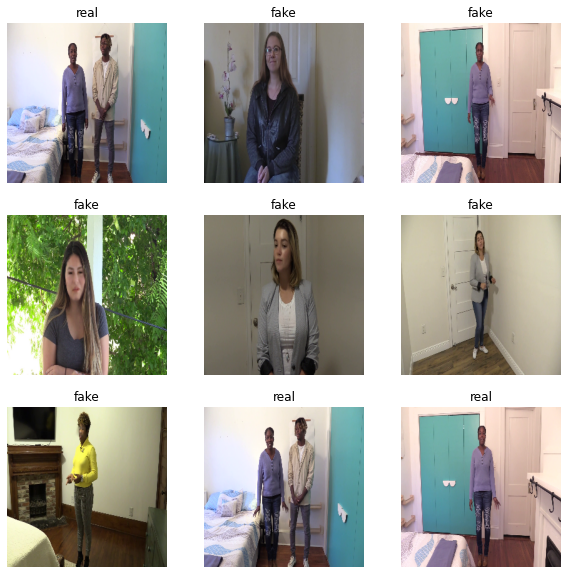

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add new layers for binary classification on top of the pre-trained model
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(vgg16_model)
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dense_4 (Dense)             (None, 8, 8, 256)         131328    
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dropout_2 (Dropout)         (None, 16384)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 16385     
                                                                 
Total params: 14,862,401
Trainable params: 14,862,401


In [84]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
100/100 [==============================] - 15s 47ms/step - loss: 0.7319 - accuracy: 0.7420 - val_loss: 0.5481 - val_accuracy: 0.7680
Epoch 2/30
100/100 [==============================] - 3s 31ms/step - loss: 0.5490 - accuracy: 0.7750 - val_loss: 0.5559 - val_accuracy: 0.7680
Epoch 3/30
100/100 [==============================] - 3s 31ms/step - loss: 0.5367 - accuracy: 0.7860 - val_loss: 0.5839 - val_accuracy: 0.7680
Epoch 4/30
100/100 [==============================] - 3s 31ms/step - loss: 0.5454 - accuracy: 0.7870 - val_loss: 0.5747 - val_accuracy: 0.7680
Epoch 5/30
100/100 [==============================] - 3s 31ms/step - loss: 0.5271 - accuracy: 0.7870 - val_loss: 0.5442 - val_accuracy: 0.7680
Epoch 6/30
100/100 [==============================] - 3s 31ms/step - loss: 0.5224 - accuracy: 0.7870 - val_loss: 0.5428 - val_accuracy: 0.7680
Epoch 7/30
100/100 [==============================] - 3s 31ms/step - loss: 0.5324 - accuracy: 0.7870 - val_loss: 0.5422 - val_accuracy: 0.768

In [85]:
model.save(data_path3+"vgg_deepfake_model_updated_rescaled3.h5")

In [86]:
# Testing the model with images from Dall-E
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

reload_model=keras.models.load_model(data_path3+'vgg_deepfake_model_updated_rescaled3.h5')
reload_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dense_4 (Dense)             (None, 8, 8, 256)         131328    
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dropout_2 (Dropout)         (None, 16384)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 16385     
                                                                 
Total params: 14,862,401
Trainable params: 14,862,401


In [91]:
test_fake=data_path3+'donald.png' # real donald trump
# test_fake=data_path3+'donaldrealfake.jpg' #generated donald trump
# test_fake=fake_path+'Image2673_1.png' #fake from training images
# test_fake=real_path+'Image2700_0.png' #real from training images

In [92]:
# load the image and convert it to the required format
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from PIL import Image

test_image = load_img(test_fake)
input_size=(256,256)
test_image=test_image.resize(input_size)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# make the prediction
result = model.predict(test_image)
# predicted_class = np.argmax(result)

1/1 [==============================] - 0s 25ms/step


In [93]:
print(result)

if (result<=0.5):
  print("Real Image")
else:
  print("Fake Image")

[[0.20247488]]
Real Image
